In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_california_housing
#Test Push

print(f"TensorFlow Version: {tf.__version__}")

In [13]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

train_adult = pd.read_csv("DataSets/census/adult.data", header=None, names=columns, sep=",", na_values=" ?", skipinitialspace=True)
test_adult = pd.read_csv("DataSets/census/adult.test", header=0, names=columns, sep=",", na_values=" ?", skipinitialspace=True, comment='|')
test_adult['income'] = test_adult['income'].str.replace('.', '', regex=False)

data_adult = pd.concat([train_adult, test_adult], ignore_index=True).dropna()


# Part 1: Feature-Level Interpretability (30 marks)  
You will use the California Housing and the Adult Census Income datasets in this part. You 
should train one feed-forward neural network for each dataset and apply the following 
interpretability techniques:

In [ ]:
# Adult Census Income Dataset pre-processing and neural network model

X_adult = data_adult.drop("income", axis=1)
y_adult = (data_adult["income"] == ">50K").astype(int)

# Identify categorical and numerical columns
cat_cols = X_adult.select_dtypes(include=['object']).columns
num_cols = X_adult.select_dtypes(exclude=['object']).columns

# Encode categorical & scale numeric
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

X_processed_adult = ct.fit_transform(X_adult)
X_train_adult, X_val_adult, y_train_adult, y_val_adult = train_test_split(X_processed_adult, y_adult, test_size=0.2, random_state=42)

input_dim = X_train_adult.shape[1]
"""
# The feed-forward neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(
    X_train_adult, y_train_adult,
    validation_data=(X_val_adult, y_val_adult),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaulate the model
loss, acc = model.evaluate(X_val_adult, y_val_adult, verbose=0)
print(f"Validation Accuracy: {acc:.4f}")
"""

from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Wrap the Keras model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap in scikit-learn compatible estimator
sklearn_model = KerasClassifier(model=create_model, epochs=10, batch_size=256, verbose=0)
sklearn_model.fit(X_train_adult, y_train_adult)


c:\Users\jamie\OneDrive\Desktop\Interpretable AI Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

KerasClassifier(
	model=<function create_model at 0x0000021E876B2040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=256
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

## 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots (7 marks) 
### a. Use PDP to examine the average effect of at least two features. 

ValueError: 'estimator' must be a fitted regressor or classifier.

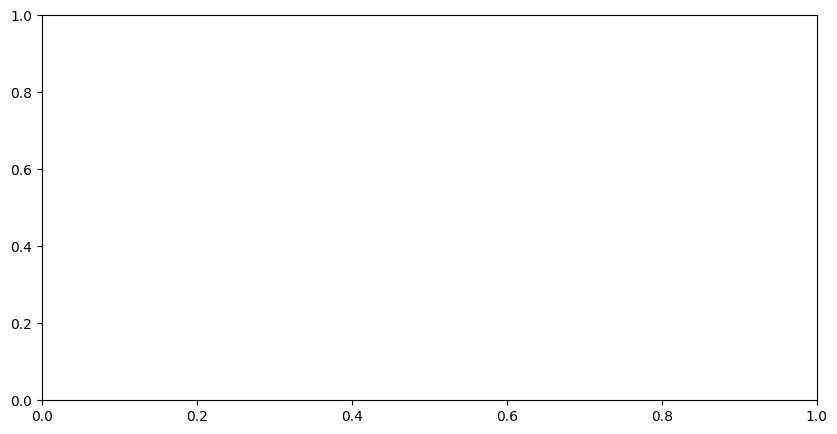

In [ ]:
# Example: 'age' and 'hours-per-week'
num_features_for_pdp = ['age', 'hours-per-week']

# Get the indices of these features after ColumnTransformer
feature_indices = [list(num_cols).index(f) + ct.transformers_[0][1].transform(X_adult[cat_cols]).shape[1] for f in num_features_for_pdp]

PartialDependenceDisplay.from_estimator(
    sklearn_model, X_train_adult, features=feature_indices,
    feature_names=num_cols, grid_resolution=20
)
plt.show()


In [ ]:
#California Housing Data Set NN + PDP + ICE

### b. Use ICE plots to explore individual predictions for at least two features. 

### c. Explain what insights PDP and ICE give about the model’s behaviour.

## 2. Permutation Feature Importance (PFI) (7 marks) 
### a. Use PFI to identify the most important features in the model. 


### b. Explain what the term “important” means when using the PFI method. 

## 3. Accumulated Local Effects (ALE) (9 marks) 
### a. Implement ALE plots to investigate the local effects of feature changes. 

### b. Compare ALE with PDP and discuss any differences in the interpretability of these techniques.

## 4. Global Surrogates (7 marks) 
### a. Build an interpretable model to approximate the predictions of the feed-forward neural network model. 

### b. Analyse the surrogate model's effectiveness and discuss when such approximations are helpful.